# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

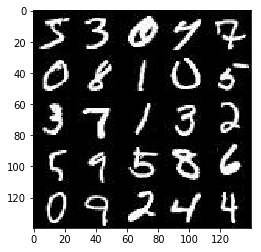

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

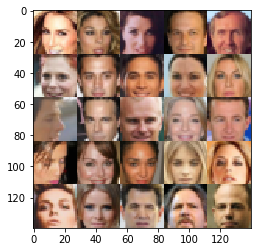

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    pl1 = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='Real_Input')
    pl2 = tf.placeholder(tf.float32, (None, z_dim), name='Z_Input')
    pl3 = tf.placeholder(tf.float32, name='Learning_Rate')

    return pl1, pl2, pl3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        l1 = tf.layers.conv2d(images, filters=64, kernel_size=(5,5), strides=(2,2), padding='same')
        l1 = tf.maximum(0.2*l1, l1)
        
        l2 = tf.layers.conv2d(l1, filters=128, kernel_size=(5,5), strides=(2,2), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l2 = tf.layers.batch_normalization(l2, training=True)
        l2 = tf.maximum(0.2*l2, l2)
        
        l3 = tf.layers.conv2d(l2, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l3 = tf.layers.batch_normalization(l3, training=True)
        l3 = tf.maximum(0.2*l3, l3)
        
        #l3 = tf.nn.dropout(l3, 0.6)
        
        l4 = tf.layers.conv2d(l3, filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        l4 = tf.layers.batch_normalization(l4, training=True)
        l4 = tf.maximum(0.2*l4, l4)
        
        flat = tf.reshape(l4, (-1,7*7*256))
        logits= tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        l1 = tf.layers.dense(z, 7*7*256)
        l1 = tf.reshape(l1, (-1,7,7,256))
        l1 = tf.layers.batch_normalization(l1, training=is_train)
        l1 = tf.maximum(0.2*l1,l1)
        
        l2 = tf.layers.conv2d_transpose(l1, 256, 5,strides=2, padding='same')
        l2 = tf.layers.batch_normalization(l2, training=is_train)
        l2 = tf.maximum(0.2*l2,l2)
        
        l3 = tf.layers.conv2d_transpose(l2, 128, 5,strides=2, padding='same')
        l3 = tf.layers.batch_normalization(l3, training=is_train)
        l3 = tf.maximum(0.2*l3,l3)
        
        #l3 = tf.nn.dropout(l3,0.6)
        
        l4 = tf.layers.conv2d_transpose(l3, 64, 5,strides=1, padding='same')
        l4 = tf.layers.batch_normalization(l4, training=is_train)
        l4 = tf.maximum(0.2*l4,l4)
        
        logits = tf.layers.conv2d_transpose(l4, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_v = tf.trainable_variables()
    d_v = [var for var in t_v if 'discriminator' in var.name]
    g_v = [var for var in t_v if 'generator' in var.name]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_v)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_v)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps=0;
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    figsize=(5,5)
    #tf.reset_default_graph()

    input_real, input_z, learning_rate1 = model_inputs(data_shape[1], data_shape[2],data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                batch_images = batch_images*2
                
                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real:batch_images})
                
                steps = steps+1
                train_loss_d = d_loss.eval({input_z:batch_z, input_real:batch_images})
                train_loss_g = g_loss.eval({input_z:batch_z})
                if steps%10==0:
                    print("Epoch {}".format(epoch_i+1), "Discriminator Loss: {:.3f}".format(train_loss_d), "Generator Loss: {:.3f}".format(train_loss_g))
                
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 Discriminator Loss: 1.218 Generator Loss: 0.589
Epoch 1 Discriminator Loss: 1.520 Generator Loss: 3.957
Epoch 1 Discriminator Loss: 2.028 Generator Loss: 0.374
Epoch 1 Discriminator Loss: 0.605 Generator Loss: 2.122
Epoch 1 Discriminator Loss: 1.370 Generator Loss: 7.732
Epoch 1 Discriminator Loss: 1.214 Generator Loss: 0.864
Epoch 1 Discriminator Loss: 1.471 Generator Loss: 0.515
Epoch 1 Discriminator Loss: 1.166 Generator Loss: 1.460
Epoch 1 Discriminator Loss: 1.054 Generator Loss: 1.059
Epoch 1 Discriminator Loss: 0.755 Generator Loss: 1.013


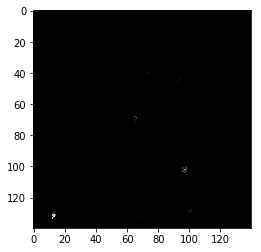

Epoch 1 Discriminator Loss: 0.904 Generator Loss: 1.119
Epoch 1 Discriminator Loss: 0.947 Generator Loss: 0.896
Epoch 1 Discriminator Loss: 1.155 Generator Loss: 0.903
Epoch 1 Discriminator Loss: 1.271 Generator Loss: 2.249
Epoch 1 Discriminator Loss: 1.182 Generator Loss: 1.000
Epoch 1 Discriminator Loss: 1.204 Generator Loss: 0.620
Epoch 1 Discriminator Loss: 1.944 Generator Loss: 2.636
Epoch 1 Discriminator Loss: 1.511 Generator Loss: 0.494
Epoch 1 Discriminator Loss: 1.109 Generator Loss: 1.390
Epoch 1 Discriminator Loss: 1.653 Generator Loss: 0.497


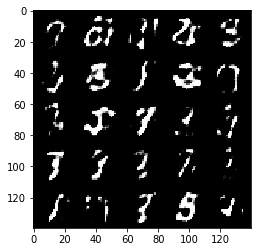

Epoch 1 Discriminator Loss: 0.730 Generator Loss: 1.803
Epoch 1 Discriminator Loss: 1.271 Generator Loss: 0.908
Epoch 1 Discriminator Loss: 1.141 Generator Loss: 0.637
Epoch 1 Discriminator Loss: 1.921 Generator Loss: 0.566
Epoch 1 Discriminator Loss: 1.481 Generator Loss: 2.052
Epoch 1 Discriminator Loss: 1.067 Generator Loss: 0.706
Epoch 1 Discriminator Loss: 1.143 Generator Loss: 0.777
Epoch 1 Discriminator Loss: 1.861 Generator Loss: 0.601
Epoch 1 Discriminator Loss: 1.049 Generator Loss: 0.799
Epoch 1 Discriminator Loss: 1.162 Generator Loss: 1.184


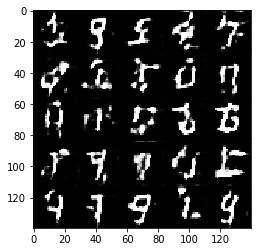

Epoch 1 Discriminator Loss: 1.484 Generator Loss: 0.390
Epoch 1 Discriminator Loss: 1.193 Generator Loss: 1.041
Epoch 1 Discriminator Loss: 1.159 Generator Loss: 0.718
Epoch 1 Discriminator Loss: 1.145 Generator Loss: 0.528
Epoch 1 Discriminator Loss: 1.199 Generator Loss: 1.952
Epoch 1 Discriminator Loss: 0.891 Generator Loss: 1.488
Epoch 1 Discriminator Loss: 1.316 Generator Loss: 0.716
Epoch 1 Discriminator Loss: 1.356 Generator Loss: 0.650
Epoch 1 Discriminator Loss: 1.289 Generator Loss: 0.918
Epoch 1 Discriminator Loss: 1.565 Generator Loss: 1.870


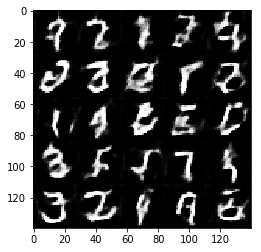

Epoch 1 Discriminator Loss: 1.273 Generator Loss: 1.135
Epoch 1 Discriminator Loss: 1.207 Generator Loss: 0.636
Epoch 1 Discriminator Loss: 1.188 Generator Loss: 1.197
Epoch 1 Discriminator Loss: 1.087 Generator Loss: 1.217
Epoch 1 Discriminator Loss: 1.361 Generator Loss: 0.946
Epoch 1 Discriminator Loss: 1.764 Generator Loss: 0.340
Epoch 1 Discriminator Loss: 1.176 Generator Loss: 1.519
Epoch 1 Discriminator Loss: 0.970 Generator Loss: 1.176
Epoch 1 Discriminator Loss: 1.118 Generator Loss: 0.662
Epoch 1 Discriminator Loss: 1.309 Generator Loss: 0.492


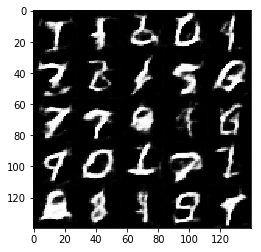

Epoch 1 Discriminator Loss: 1.308 Generator Loss: 0.847
Epoch 1 Discriminator Loss: 1.557 Generator Loss: 0.411
Epoch 1 Discriminator Loss: 1.359 Generator Loss: 1.564
Epoch 1 Discriminator Loss: 1.209 Generator Loss: 0.954
Epoch 1 Discriminator Loss: 0.950 Generator Loss: 1.110
Epoch 1 Discriminator Loss: 1.213 Generator Loss: 1.213
Epoch 1 Discriminator Loss: 1.880 Generator Loss: 0.302
Epoch 1 Discriminator Loss: 1.019 Generator Loss: 1.301
Epoch 1 Discriminator Loss: 1.423 Generator Loss: 0.492
Epoch 1 Discriminator Loss: 1.087 Generator Loss: 1.056


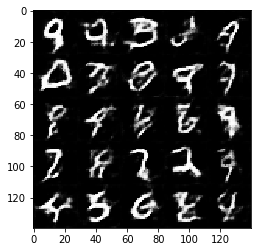

Epoch 1 Discriminator Loss: 1.237 Generator Loss: 0.885
Epoch 1 Discriminator Loss: 1.204 Generator Loss: 1.244
Epoch 1 Discriminator Loss: 1.209 Generator Loss: 0.717
Epoch 1 Discriminator Loss: 0.967 Generator Loss: 0.856
Epoch 1 Discriminator Loss: 1.398 Generator Loss: 0.540
Epoch 1 Discriminator Loss: 1.268 Generator Loss: 0.788
Epoch 1 Discriminator Loss: 1.171 Generator Loss: 1.334
Epoch 1 Discriminator Loss: 1.805 Generator Loss: 0.351
Epoch 1 Discriminator Loss: 1.103 Generator Loss: 1.012
Epoch 1 Discriminator Loss: 1.120 Generator Loss: 0.602


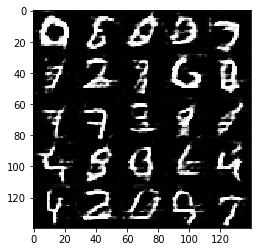

Epoch 1 Discriminator Loss: 1.325 Generator Loss: 0.624
Epoch 1 Discriminator Loss: 1.194 Generator Loss: 0.663
Epoch 1 Discriminator Loss: 1.433 Generator Loss: 1.783
Epoch 1 Discriminator Loss: 1.082 Generator Loss: 0.684
Epoch 1 Discriminator Loss: 1.450 Generator Loss: 0.968
Epoch 1 Discriminator Loss: 1.028 Generator Loss: 1.013
Epoch 1 Discriminator Loss: 1.583 Generator Loss: 0.317
Epoch 1 Discriminator Loss: 1.244 Generator Loss: 0.787
Epoch 1 Discriminator Loss: 1.285 Generator Loss: 0.911
Epoch 1 Discriminator Loss: 1.682 Generator Loss: 0.373


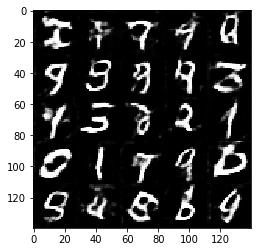

Epoch 1 Discriminator Loss: 1.371 Generator Loss: 0.568
Epoch 1 Discriminator Loss: 1.089 Generator Loss: 0.834
Epoch 1 Discriminator Loss: 1.231 Generator Loss: 0.599
Epoch 1 Discriminator Loss: 0.911 Generator Loss: 0.834
Epoch 1 Discriminator Loss: 1.255 Generator Loss: 1.716
Epoch 1 Discriminator Loss: 1.923 Generator Loss: 0.384
Epoch 1 Discriminator Loss: 1.579 Generator Loss: 0.502
Epoch 1 Discriminator Loss: 1.166 Generator Loss: 0.580
Epoch 1 Discriminator Loss: 1.131 Generator Loss: 0.819
Epoch 1 Discriminator Loss: 1.111 Generator Loss: 0.930


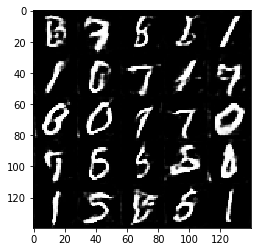

Epoch 1 Discriminator Loss: 1.302 Generator Loss: 0.720
Epoch 1 Discriminator Loss: 1.184 Generator Loss: 0.663
Epoch 1 Discriminator Loss: 1.784 Generator Loss: 0.322
Epoch 2 Discriminator Loss: 1.420 Generator Loss: 0.464
Epoch 2 Discriminator Loss: 1.075 Generator Loss: 1.199
Epoch 2 Discriminator Loss: 1.221 Generator Loss: 1.397
Epoch 2 Discriminator Loss: 1.820 Generator Loss: 0.319
Epoch 2 Discriminator Loss: 1.123 Generator Loss: 0.922
Epoch 2 Discriminator Loss: 1.408 Generator Loss: 0.677
Epoch 2 Discriminator Loss: 1.232 Generator Loss: 0.894


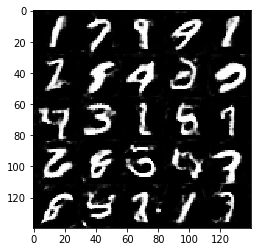

Epoch 2 Discriminator Loss: 1.138 Generator Loss: 1.012
Epoch 2 Discriminator Loss: 1.223 Generator Loss: 1.300
Epoch 2 Discriminator Loss: 0.958 Generator Loss: 1.240
Epoch 2 Discriminator Loss: 1.080 Generator Loss: 1.286
Epoch 2 Discriminator Loss: 1.657 Generator Loss: 0.308
Epoch 2 Discriminator Loss: 1.148 Generator Loss: 0.674
Epoch 2 Discriminator Loss: 1.235 Generator Loss: 1.024
Epoch 2 Discriminator Loss: 1.191 Generator Loss: 1.327
Epoch 2 Discriminator Loss: 1.086 Generator Loss: 0.882
Epoch 2 Discriminator Loss: 1.386 Generator Loss: 0.503


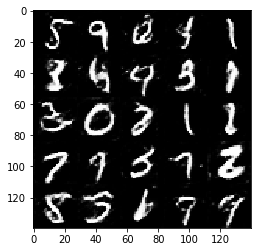

Epoch 2 Discriminator Loss: 1.066 Generator Loss: 1.073
Epoch 2 Discriminator Loss: 1.166 Generator Loss: 0.600
Epoch 2 Discriminator Loss: 1.106 Generator Loss: 0.943
Epoch 2 Discriminator Loss: 1.078 Generator Loss: 0.791
Epoch 2 Discriminator Loss: 1.232 Generator Loss: 0.681
Epoch 2 Discriminator Loss: 1.200 Generator Loss: 0.666
Epoch 2 Discriminator Loss: 1.170 Generator Loss: 0.730
Epoch 2 Discriminator Loss: 1.345 Generator Loss: 0.842
Epoch 2 Discriminator Loss: 1.441 Generator Loss: 0.420
Epoch 2 Discriminator Loss: 1.510 Generator Loss: 0.447


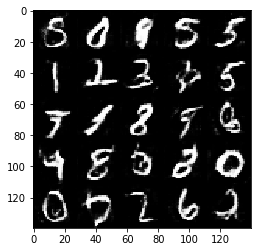

Epoch 2 Discriminator Loss: 1.042 Generator Loss: 1.618
Epoch 2 Discriminator Loss: 0.929 Generator Loss: 1.298
Epoch 2 Discriminator Loss: 1.068 Generator Loss: 0.933
Epoch 2 Discriminator Loss: 1.643 Generator Loss: 0.315
Epoch 2 Discriminator Loss: 1.394 Generator Loss: 1.136
Epoch 2 Discriminator Loss: 1.345 Generator Loss: 1.857
Epoch 2 Discriminator Loss: 1.657 Generator Loss: 0.434
Epoch 2 Discriminator Loss: 1.344 Generator Loss: 0.538
Epoch 2 Discriminator Loss: 0.978 Generator Loss: 0.814
Epoch 2 Discriminator Loss: 1.282 Generator Loss: 1.052


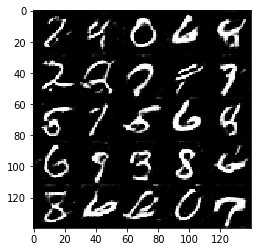

Epoch 2 Discriminator Loss: 1.890 Generator Loss: 0.267
Epoch 2 Discriminator Loss: 1.307 Generator Loss: 1.680
Epoch 2 Discriminator Loss: 1.105 Generator Loss: 0.870
Epoch 2 Discriminator Loss: 1.415 Generator Loss: 1.466
Epoch 2 Discriminator Loss: 1.730 Generator Loss: 0.352
Epoch 2 Discriminator Loss: 1.584 Generator Loss: 2.383
Epoch 2 Discriminator Loss: 1.135 Generator Loss: 1.182
Epoch 2 Discriminator Loss: 1.000 Generator Loss: 0.994
Epoch 2 Discriminator Loss: 1.006 Generator Loss: 0.823
Epoch 2 Discriminator Loss: 1.249 Generator Loss: 1.645


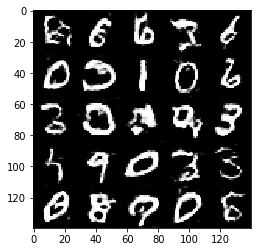

Epoch 2 Discriminator Loss: 1.363 Generator Loss: 0.640
Epoch 2 Discriminator Loss: 1.735 Generator Loss: 2.764
Epoch 2 Discriminator Loss: 1.169 Generator Loss: 1.072
Epoch 2 Discriminator Loss: 0.877 Generator Loss: 1.340
Epoch 2 Discriminator Loss: 1.259 Generator Loss: 0.924
Epoch 2 Discriminator Loss: 1.256 Generator Loss: 0.846
Epoch 2 Discriminator Loss: 1.068 Generator Loss: 0.793
Epoch 2 Discriminator Loss: 1.274 Generator Loss: 0.573
Epoch 2 Discriminator Loss: 1.116 Generator Loss: 1.513
Epoch 2 Discriminator Loss: 1.125 Generator Loss: 0.742


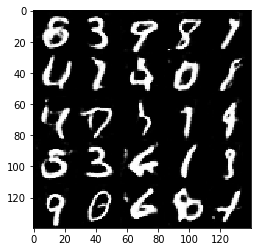

Epoch 2 Discriminator Loss: 1.137 Generator Loss: 0.850
Epoch 2 Discriminator Loss: 0.954 Generator Loss: 1.077
Epoch 2 Discriminator Loss: 1.068 Generator Loss: 0.864
Epoch 2 Discriminator Loss: 0.863 Generator Loss: 1.185
Epoch 2 Discriminator Loss: 1.850 Generator Loss: 0.324
Epoch 2 Discriminator Loss: 1.793 Generator Loss: 0.320
Epoch 2 Discriminator Loss: 1.318 Generator Loss: 0.985
Epoch 2 Discriminator Loss: 1.025 Generator Loss: 0.776
Epoch 2 Discriminator Loss: 1.396 Generator Loss: 0.457
Epoch 2 Discriminator Loss: 1.512 Generator Loss: 0.661


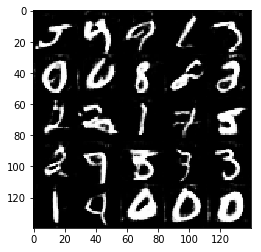

Epoch 2 Discriminator Loss: 1.282 Generator Loss: 0.703
Epoch 2 Discriminator Loss: 1.078 Generator Loss: 0.799
Epoch 2 Discriminator Loss: 1.064 Generator Loss: 1.257
Epoch 2 Discriminator Loss: 1.226 Generator Loss: 1.292
Epoch 2 Discriminator Loss: 1.066 Generator Loss: 0.933
Epoch 2 Discriminator Loss: 0.808 Generator Loss: 1.949
Epoch 2 Discriminator Loss: 1.318 Generator Loss: 0.797
Epoch 2 Discriminator Loss: 0.906 Generator Loss: 1.019
Epoch 2 Discriminator Loss: 1.522 Generator Loss: 0.402
Epoch 2 Discriminator Loss: 2.328 Generator Loss: 0.200


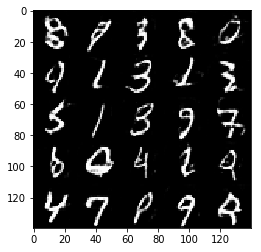

Epoch 2 Discriminator Loss: 1.286 Generator Loss: 0.639
Epoch 2 Discriminator Loss: 1.285 Generator Loss: 0.778
Epoch 2 Discriminator Loss: 1.331 Generator Loss: 0.527
Epoch 2 Discriminator Loss: 1.109 Generator Loss: 0.669
Epoch 2 Discriminator Loss: 0.965 Generator Loss: 2.096
Epoch 2 Discriminator Loss: 0.840 Generator Loss: 1.016
Epoch 2 Discriminator Loss: 1.087 Generator Loss: 0.952
Epoch 2 Discriminator Loss: 2.099 Generator Loss: 0.264
Epoch 2 Discriminator Loss: 0.729 Generator Loss: 1.743
Epoch 2 Discriminator Loss: 1.055 Generator Loss: 0.734


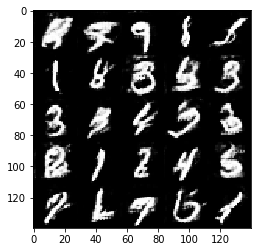

Epoch 2 Discriminator Loss: 1.170 Generator Loss: 0.996
Epoch 2 Discriminator Loss: 1.128 Generator Loss: 1.724
Epoch 2 Discriminator Loss: 0.991 Generator Loss: 1.029
Epoch 2 Discriminator Loss: 0.972 Generator Loss: 0.836
Epoch 2 Discriminator Loss: 1.139 Generator Loss: 0.995
Epoch 2 Discriminator Loss: 1.005 Generator Loss: 2.167
Epoch 2 Discriminator Loss: 0.734 Generator Loss: 1.351


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 Discriminator Loss: 1.231 Generator Loss: 0.700
Epoch 1 Discriminator Loss: 2.792 Generator Loss: 1.451
Epoch 1 Discriminator Loss: 1.003 Generator Loss: 2.446
Epoch 1 Discriminator Loss: 1.315 Generator Loss: 0.661
Epoch 1 Discriminator Loss: 1.557 Generator Loss: 0.800
Epoch 1 Discriminator Loss: 0.634 Generator Loss: 1.987
Epoch 1 Discriminator Loss: 0.402 Generator Loss: 2.163
Epoch 1 Discriminator Loss: 1.079 Generator Loss: 6.611
Epoch 1 Discriminator Loss: 0.305 Generator Loss: 2.791
Epoch 1 Discriminator Loss: 0.498 Generator Loss: 1.564


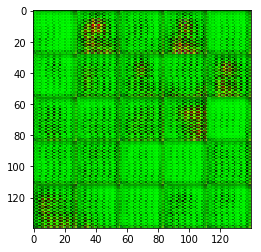

Epoch 1 Discriminator Loss: 0.412 Generator Loss: 1.590
Epoch 1 Discriminator Loss: 0.509 Generator Loss: 2.214
Epoch 1 Discriminator Loss: 0.789 Generator Loss: 1.585
Epoch 1 Discriminator Loss: 0.401 Generator Loss: 1.612
Epoch 1 Discriminator Loss: 1.003 Generator Loss: 1.529
Epoch 1 Discriminator Loss: 3.758 Generator Loss: 0.106
Epoch 1 Discriminator Loss: 1.693 Generator Loss: 0.408
Epoch 1 Discriminator Loss: 1.759 Generator Loss: 0.371
Epoch 1 Discriminator Loss: 1.138 Generator Loss: 1.342
Epoch 1 Discriminator Loss: 1.188 Generator Loss: 0.900


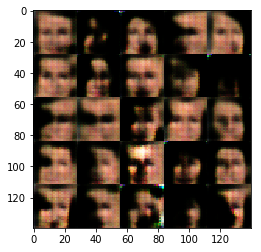

Epoch 1 Discriminator Loss: 0.825 Generator Loss: 1.253
Epoch 1 Discriminator Loss: 1.195 Generator Loss: 1.218
Epoch 1 Discriminator Loss: 0.887 Generator Loss: 0.856
Epoch 1 Discriminator Loss: 1.284 Generator Loss: 0.572
Epoch 1 Discriminator Loss: 0.948 Generator Loss: 0.949
Epoch 1 Discriminator Loss: 1.263 Generator Loss: 0.572
Epoch 1 Discriminator Loss: 1.441 Generator Loss: 1.527
Epoch 1 Discriminator Loss: 1.373 Generator Loss: 0.798
Epoch 1 Discriminator Loss: 1.825 Generator Loss: 0.978
Epoch 1 Discriminator Loss: 2.097 Generator Loss: 0.245


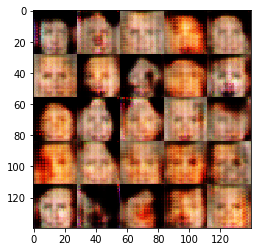

Epoch 1 Discriminator Loss: 1.730 Generator Loss: 0.400
Epoch 1 Discriminator Loss: 0.861 Generator Loss: 1.158
Epoch 1 Discriminator Loss: 1.473 Generator Loss: 0.682
Epoch 1 Discriminator Loss: 0.892 Generator Loss: 0.943
Epoch 1 Discriminator Loss: 1.464 Generator Loss: 1.480
Epoch 1 Discriminator Loss: 1.260 Generator Loss: 0.899
Epoch 1 Discriminator Loss: 1.228 Generator Loss: 1.168
Epoch 1 Discriminator Loss: 1.483 Generator Loss: 0.638
Epoch 1 Discriminator Loss: 1.318 Generator Loss: 1.136
Epoch 1 Discriminator Loss: 1.766 Generator Loss: 1.440


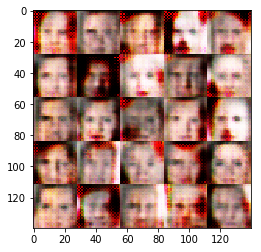

Epoch 1 Discriminator Loss: 1.210 Generator Loss: 0.646
Epoch 1 Discriminator Loss: 1.564 Generator Loss: 0.700
Epoch 1 Discriminator Loss: 0.907 Generator Loss: 0.892
Epoch 1 Discriminator Loss: 1.420 Generator Loss: 0.508
Epoch 1 Discriminator Loss: 1.344 Generator Loss: 0.612
Epoch 1 Discriminator Loss: 1.226 Generator Loss: 0.713
Epoch 1 Discriminator Loss: 1.322 Generator Loss: 0.919
Epoch 1 Discriminator Loss: 1.691 Generator Loss: 2.153
Epoch 1 Discriminator Loss: 1.006 Generator Loss: 0.717
Epoch 1 Discriminator Loss: 1.329 Generator Loss: 1.425


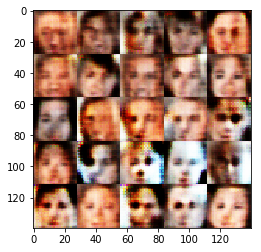

Epoch 1 Discriminator Loss: 1.335 Generator Loss: 1.192
Epoch 1 Discriminator Loss: 1.435 Generator Loss: 0.458
Epoch 1 Discriminator Loss: 2.418 Generator Loss: 0.190
Epoch 1 Discriminator Loss: 1.427 Generator Loss: 0.845
Epoch 1 Discriminator Loss: 1.067 Generator Loss: 1.031
Epoch 1 Discriminator Loss: 1.515 Generator Loss: 1.824
Epoch 1 Discriminator Loss: 1.415 Generator Loss: 0.371
Epoch 1 Discriminator Loss: 1.207 Generator Loss: 1.165
Epoch 1 Discriminator Loss: 1.281 Generator Loss: 0.828
Epoch 1 Discriminator Loss: 1.197 Generator Loss: 0.758


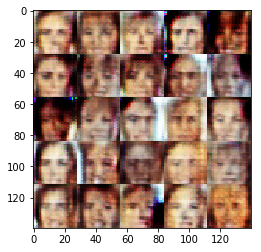

Epoch 1 Discriminator Loss: 1.413 Generator Loss: 0.538
Epoch 1 Discriminator Loss: 1.331 Generator Loss: 0.502
Epoch 1 Discriminator Loss: 0.933 Generator Loss: 1.343
Epoch 1 Discriminator Loss: 1.442 Generator Loss: 0.727
Epoch 1 Discriminator Loss: 1.216 Generator Loss: 0.848
Epoch 1 Discriminator Loss: 0.935 Generator Loss: 0.988
Epoch 1 Discriminator Loss: 0.939 Generator Loss: 1.213
Epoch 1 Discriminator Loss: 1.463 Generator Loss: 0.652
Epoch 1 Discriminator Loss: 2.120 Generator Loss: 0.206
Epoch 1 Discriminator Loss: 1.297 Generator Loss: 0.956


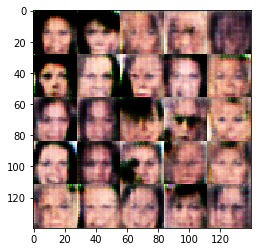

Epoch 1 Discriminator Loss: 1.233 Generator Loss: 1.029
Epoch 1 Discriminator Loss: 1.353 Generator Loss: 0.452
Epoch 1 Discriminator Loss: 1.506 Generator Loss: 0.925
Epoch 1 Discriminator Loss: 1.376 Generator Loss: 0.585
Epoch 1 Discriminator Loss: 1.603 Generator Loss: 0.839
Epoch 1 Discriminator Loss: 1.046 Generator Loss: 0.680
Epoch 1 Discriminator Loss: 1.268 Generator Loss: 0.900
Epoch 1 Discriminator Loss: 1.053 Generator Loss: 1.313
Epoch 1 Discriminator Loss: 1.101 Generator Loss: 0.778
Epoch 1 Discriminator Loss: 1.303 Generator Loss: 1.073


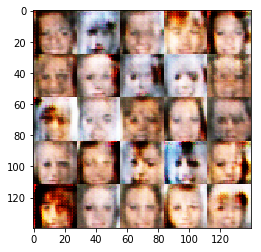

Epoch 1 Discriminator Loss: 1.379 Generator Loss: 1.265
Epoch 1 Discriminator Loss: 1.171 Generator Loss: 0.845
Epoch 1 Discriminator Loss: 1.243 Generator Loss: 0.593
Epoch 1 Discriminator Loss: 1.036 Generator Loss: 0.817
Epoch 1 Discriminator Loss: 1.430 Generator Loss: 0.422
Epoch 1 Discriminator Loss: 1.367 Generator Loss: 0.591
Epoch 1 Discriminator Loss: 1.486 Generator Loss: 0.522
Epoch 1 Discriminator Loss: 0.435 Generator Loss: 1.370
Epoch 1 Discriminator Loss: 1.060 Generator Loss: 0.588
Epoch 1 Discriminator Loss: 0.367 Generator Loss: 1.415


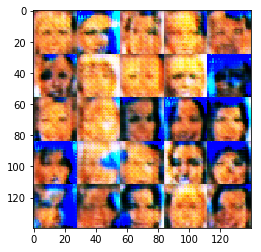

Epoch 1 Discriminator Loss: 1.311 Generator Loss: 2.246
Epoch 1 Discriminator Loss: 1.302 Generator Loss: 0.667
Epoch 1 Discriminator Loss: 1.014 Generator Loss: 0.674
Epoch 1 Discriminator Loss: 1.500 Generator Loss: 0.530
Epoch 1 Discriminator Loss: 1.149 Generator Loss: 0.960
Epoch 1 Discriminator Loss: 1.085 Generator Loss: 1.101
Epoch 1 Discriminator Loss: 0.968 Generator Loss: 1.089
Epoch 1 Discriminator Loss: 1.472 Generator Loss: 1.506
Epoch 1 Discriminator Loss: 1.358 Generator Loss: 0.933
Epoch 1 Discriminator Loss: 1.230 Generator Loss: 0.925


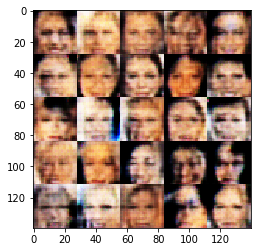

Epoch 1 Discriminator Loss: 1.459 Generator Loss: 1.093
Epoch 1 Discriminator Loss: 1.233 Generator Loss: 1.039
Epoch 1 Discriminator Loss: 1.451 Generator Loss: 0.656
Epoch 1 Discriminator Loss: 1.218 Generator Loss: 1.419
Epoch 1 Discriminator Loss: 1.586 Generator Loss: 0.780
Epoch 1 Discriminator Loss: 1.056 Generator Loss: 0.969
Epoch 1 Discriminator Loss: 1.004 Generator Loss: 0.719
Epoch 1 Discriminator Loss: 1.114 Generator Loss: 0.955
Epoch 1 Discriminator Loss: 1.344 Generator Loss: 0.515
Epoch 1 Discriminator Loss: 1.016 Generator Loss: 1.038


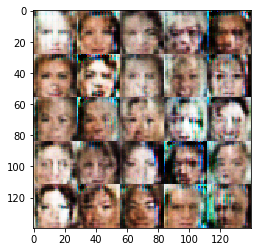

Epoch 1 Discriminator Loss: 1.096 Generator Loss: 0.930
Epoch 1 Discriminator Loss: 1.762 Generator Loss: 0.413
Epoch 1 Discriminator Loss: 1.265 Generator Loss: 0.980
Epoch 1 Discriminator Loss: 1.132 Generator Loss: 1.092
Epoch 1 Discriminator Loss: 1.256 Generator Loss: 0.582
Epoch 1 Discriminator Loss: 1.185 Generator Loss: 1.111
Epoch 1 Discriminator Loss: 1.213 Generator Loss: 0.769
Epoch 1 Discriminator Loss: 0.982 Generator Loss: 0.750
Epoch 1 Discriminator Loss: 1.238 Generator Loss: 0.915
Epoch 1 Discriminator Loss: 1.147 Generator Loss: 1.412


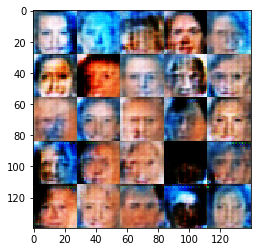

Epoch 1 Discriminator Loss: 1.777 Generator Loss: 1.888
Epoch 1 Discriminator Loss: 1.295 Generator Loss: 0.531
Epoch 1 Discriminator Loss: 1.095 Generator Loss: 0.650
Epoch 1 Discriminator Loss: 1.212 Generator Loss: 0.724
Epoch 1 Discriminator Loss: 1.322 Generator Loss: 0.870
Epoch 1 Discriminator Loss: 1.100 Generator Loss: 1.020
Epoch 1 Discriminator Loss: 1.430 Generator Loss: 0.408
Epoch 1 Discriminator Loss: 1.054 Generator Loss: 0.730
Epoch 1 Discriminator Loss: 1.292 Generator Loss: 0.896
Epoch 1 Discriminator Loss: 0.924 Generator Loss: 0.945


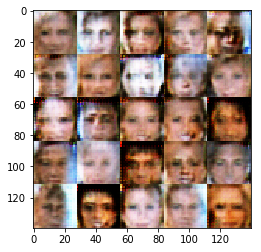

Epoch 1 Discriminator Loss: 1.304 Generator Loss: 0.570
Epoch 1 Discriminator Loss: 1.140 Generator Loss: 0.713
Epoch 1 Discriminator Loss: 1.519 Generator Loss: 0.418
Epoch 1 Discriminator Loss: 0.498 Generator Loss: 2.289
Epoch 1 Discriminator Loss: 1.106 Generator Loss: 1.872
Epoch 1 Discriminator Loss: 1.064 Generator Loss: 0.830
Epoch 1 Discriminator Loss: 1.242 Generator Loss: 0.768
Epoch 1 Discriminator Loss: 1.271 Generator Loss: 0.424
Epoch 1 Discriminator Loss: 1.281 Generator Loss: 0.942
Epoch 1 Discriminator Loss: 1.462 Generator Loss: 0.967


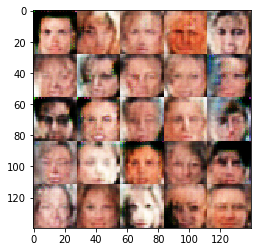

Epoch 1 Discriminator Loss: 1.364 Generator Loss: 0.847
Epoch 1 Discriminator Loss: 1.434 Generator Loss: 0.583
Epoch 1 Discriminator Loss: 1.051 Generator Loss: 1.014
Epoch 1 Discriminator Loss: 1.352 Generator Loss: 0.965
Epoch 1 Discriminator Loss: 1.122 Generator Loss: 0.783
Epoch 1 Discriminator Loss: 1.192 Generator Loss: 0.806
Epoch 1 Discriminator Loss: 1.186 Generator Loss: 1.201
Epoch 1 Discriminator Loss: 1.132 Generator Loss: 0.845
Epoch 1 Discriminator Loss: 1.350 Generator Loss: 0.757
Epoch 1 Discriminator Loss: 1.511 Generator Loss: 0.741


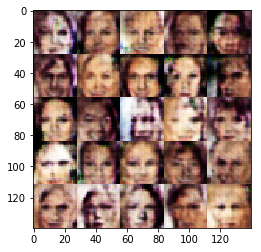

Epoch 1 Discriminator Loss: 1.442 Generator Loss: 0.691
Epoch 1 Discriminator Loss: 1.316 Generator Loss: 1.329
Epoch 1 Discriminator Loss: 1.358 Generator Loss: 0.818
Epoch 1 Discriminator Loss: 1.301 Generator Loss: 0.588
Epoch 1 Discriminator Loss: 1.400 Generator Loss: 0.797
Epoch 1 Discriminator Loss: 1.252 Generator Loss: 0.626
Epoch 1 Discriminator Loss: 1.300 Generator Loss: 0.731
Epoch 1 Discriminator Loss: 1.267 Generator Loss: 0.861
Epoch 1 Discriminator Loss: 1.480 Generator Loss: 0.598
Epoch 1 Discriminator Loss: 1.258 Generator Loss: 0.566


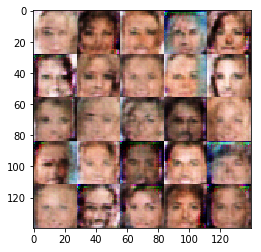

Epoch 1 Discriminator Loss: 1.331 Generator Loss: 1.186
Epoch 1 Discriminator Loss: 0.988 Generator Loss: 1.094
Epoch 1 Discriminator Loss: 1.167 Generator Loss: 0.738
Epoch 1 Discriminator Loss: 1.129 Generator Loss: 0.816
Epoch 1 Discriminator Loss: 1.115 Generator Loss: 0.946
Epoch 1 Discriminator Loss: 1.134 Generator Loss: 0.835
Epoch 1 Discriminator Loss: 1.412 Generator Loss: 0.436
Epoch 1 Discriminator Loss: 1.116 Generator Loss: 0.632
Epoch 1 Discriminator Loss: 1.150 Generator Loss: 1.014
Epoch 1 Discriminator Loss: 0.829 Generator Loss: 1.197


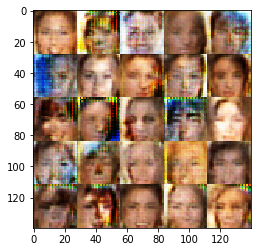

Epoch 1 Discriminator Loss: 0.891 Generator Loss: 0.938
Epoch 1 Discriminator Loss: 1.252 Generator Loss: 1.429
Epoch 1 Discriminator Loss: 1.487 Generator Loss: 0.583
Epoch 1 Discriminator Loss: 1.702 Generator Loss: 0.269
Epoch 1 Discriminator Loss: 1.157 Generator Loss: 0.699
Epoch 1 Discriminator Loss: 1.268 Generator Loss: 0.554
Epoch 1 Discriminator Loss: 1.217 Generator Loss: 0.708
Epoch 1 Discriminator Loss: 1.088 Generator Loss: 0.797
Epoch 1 Discriminator Loss: 1.345 Generator Loss: 0.541
Epoch 1 Discriminator Loss: 1.129 Generator Loss: 0.953


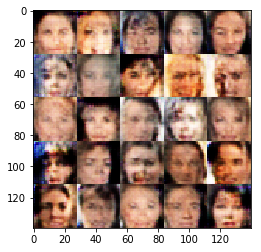

Epoch 1 Discriminator Loss: 1.314 Generator Loss: 0.610
Epoch 1 Discriminator Loss: 1.300 Generator Loss: 0.864
Epoch 1 Discriminator Loss: 1.025 Generator Loss: 0.934
Epoch 1 Discriminator Loss: 1.431 Generator Loss: 0.521
Epoch 1 Discriminator Loss: 1.326 Generator Loss: 0.568
Epoch 1 Discriminator Loss: 1.187 Generator Loss: 1.274
Epoch 1 Discriminator Loss: 1.268 Generator Loss: 0.657
Epoch 1 Discriminator Loss: 1.395 Generator Loss: 0.513
Epoch 1 Discriminator Loss: 1.443 Generator Loss: 0.957
Epoch 1 Discriminator Loss: 1.138 Generator Loss: 0.733


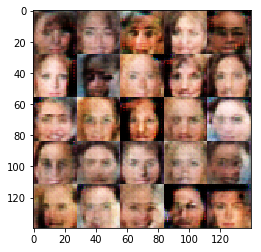

Epoch 1 Discriminator Loss: 1.132 Generator Loss: 0.692
Epoch 1 Discriminator Loss: 1.018 Generator Loss: 0.877
Epoch 1 Discriminator Loss: 1.393 Generator Loss: 1.035
Epoch 1 Discriminator Loss: 1.420 Generator Loss: 0.574
Epoch 1 Discriminator Loss: 1.376 Generator Loss: 1.153
Epoch 1 Discriminator Loss: 1.095 Generator Loss: 0.574
Epoch 1 Discriminator Loss: 1.427 Generator Loss: 0.638
Epoch 1 Discriminator Loss: 1.376 Generator Loss: 1.016
Epoch 1 Discriminator Loss: 1.285 Generator Loss: 0.724
Epoch 1 Discriminator Loss: 1.283 Generator Loss: 0.550


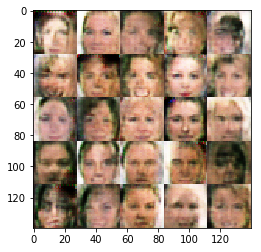

Epoch 1 Discriminator Loss: 1.232 Generator Loss: 0.759
Epoch 1 Discriminator Loss: 1.040 Generator Loss: 0.748
Epoch 1 Discriminator Loss: 1.159 Generator Loss: 0.771
Epoch 1 Discriminator Loss: 1.050 Generator Loss: 0.760
Epoch 1 Discriminator Loss: 1.575 Generator Loss: 0.632
Epoch 1 Discriminator Loss: 1.209 Generator Loss: 0.839
Epoch 1 Discriminator Loss: 1.775 Generator Loss: 0.389
Epoch 1 Discriminator Loss: 1.380 Generator Loss: 0.939
Epoch 1 Discriminator Loss: 1.249 Generator Loss: 0.744
Epoch 1 Discriminator Loss: 1.359 Generator Loss: 0.868


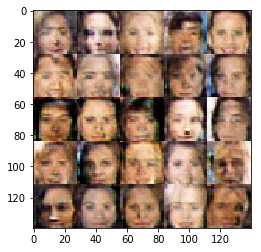

Epoch 1 Discriminator Loss: 1.066 Generator Loss: 0.676
Epoch 1 Discriminator Loss: 1.264 Generator Loss: 0.682
Epoch 1 Discriminator Loss: 1.299 Generator Loss: 0.717
Epoch 1 Discriminator Loss: 1.322 Generator Loss: 0.858
Epoch 1 Discriminator Loss: 1.128 Generator Loss: 0.718
Epoch 1 Discriminator Loss: 1.270 Generator Loss: 0.725
Epoch 1 Discriminator Loss: 1.214 Generator Loss: 0.675
Epoch 1 Discriminator Loss: 1.179 Generator Loss: 0.670
Epoch 1 Discriminator Loss: 1.396 Generator Loss: 0.705
Epoch 1 Discriminator Loss: 1.168 Generator Loss: 0.951


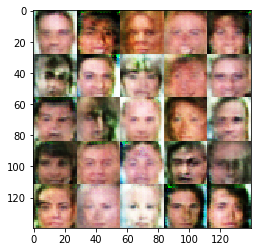

Epoch 1 Discriminator Loss: 1.095 Generator Loss: 0.855
Epoch 1 Discriminator Loss: 1.090 Generator Loss: 0.765
Epoch 1 Discriminator Loss: 1.273 Generator Loss: 0.732
Epoch 1 Discriminator Loss: 1.294 Generator Loss: 0.957
Epoch 1 Discriminator Loss: 1.262 Generator Loss: 0.666
Epoch 1 Discriminator Loss: 1.296 Generator Loss: 0.693
Epoch 1 Discriminator Loss: 1.235 Generator Loss: 0.637
Epoch 1 Discriminator Loss: 1.368 Generator Loss: 0.960
Epoch 1 Discriminator Loss: 1.252 Generator Loss: 0.872
Epoch 1 Discriminator Loss: 1.271 Generator Loss: 0.933


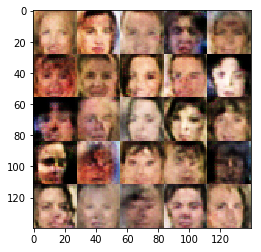

Epoch 1 Discriminator Loss: 1.244 Generator Loss: 0.956
Epoch 1 Discriminator Loss: 1.194 Generator Loss: 0.720
Epoch 1 Discriminator Loss: 1.208 Generator Loss: 0.748
Epoch 1 Discriminator Loss: 1.281 Generator Loss: 0.714
Epoch 1 Discriminator Loss: 1.365 Generator Loss: 0.922
Epoch 1 Discriminator Loss: 1.424 Generator Loss: 0.764
Epoch 1 Discriminator Loss: 1.350 Generator Loss: 0.931
Epoch 1 Discriminator Loss: 0.999 Generator Loss: 0.945
Epoch 1 Discriminator Loss: 1.136 Generator Loss: 0.750
Epoch 1 Discriminator Loss: 1.411 Generator Loss: 1.236


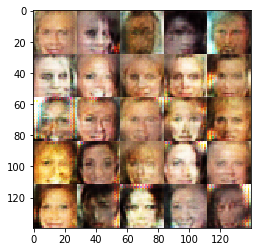

Epoch 1 Discriminator Loss: 1.028 Generator Loss: 0.853
Epoch 1 Discriminator Loss: 1.157 Generator Loss: 0.726
Epoch 1 Discriminator Loss: 0.993 Generator Loss: 1.150
Epoch 1 Discriminator Loss: 1.689 Generator Loss: 0.486
Epoch 1 Discriminator Loss: 1.873 Generator Loss: 0.557
Epoch 1 Discriminator Loss: 1.585 Generator Loss: 0.981
Epoch 1 Discriminator Loss: 1.256 Generator Loss: 0.937
Epoch 1 Discriminator Loss: 1.317 Generator Loss: 0.719
Epoch 1 Discriminator Loss: 1.076 Generator Loss: 0.927
Epoch 1 Discriminator Loss: 1.256 Generator Loss: 0.611


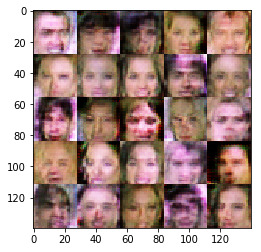

Epoch 1 Discriminator Loss: 1.319 Generator Loss: 0.847
Epoch 1 Discriminator Loss: 1.281 Generator Loss: 0.803
Epoch 1 Discriminator Loss: 1.325 Generator Loss: 0.901
Epoch 1 Discriminator Loss: 1.184 Generator Loss: 0.742
Epoch 1 Discriminator Loss: 1.765 Generator Loss: 0.341
Epoch 1 Discriminator Loss: 1.098 Generator Loss: 0.771
Epoch 1 Discriminator Loss: 1.271 Generator Loss: 0.675
Epoch 1 Discriminator Loss: 1.578 Generator Loss: 1.186
Epoch 1 Discriminator Loss: 1.261 Generator Loss: 0.825
Epoch 1 Discriminator Loss: 1.202 Generator Loss: 0.844


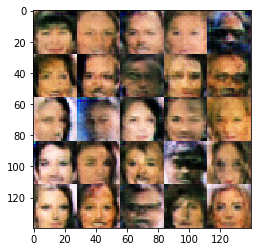

Epoch 1 Discriminator Loss: 1.091 Generator Loss: 0.768
Epoch 1 Discriminator Loss: 1.188 Generator Loss: 0.644
Epoch 1 Discriminator Loss: 1.004 Generator Loss: 0.794
Epoch 1 Discriminator Loss: 1.169 Generator Loss: 0.599
Epoch 1 Discriminator Loss: 1.100 Generator Loss: 0.692
Epoch 1 Discriminator Loss: 1.494 Generator Loss: 1.003
Epoch 1 Discriminator Loss: 1.234 Generator Loss: 0.718
Epoch 1 Discriminator Loss: 1.329 Generator Loss: 0.995
Epoch 1 Discriminator Loss: 1.239 Generator Loss: 0.840
Epoch 1 Discriminator Loss: 1.001 Generator Loss: 0.887


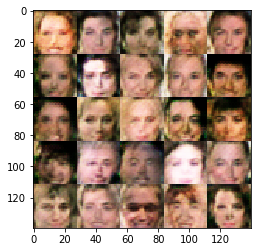

Epoch 1 Discriminator Loss: 1.322 Generator Loss: 0.674
Epoch 1 Discriminator Loss: 1.512 Generator Loss: 0.706
Epoch 1 Discriminator Loss: 1.450 Generator Loss: 0.717
Epoch 1 Discriminator Loss: 1.340 Generator Loss: 0.751
Epoch 1 Discriminator Loss: 1.476 Generator Loss: 0.616
Epoch 1 Discriminator Loss: 1.092 Generator Loss: 0.748
Epoch 1 Discriminator Loss: 1.348 Generator Loss: 0.635
Epoch 1 Discriminator Loss: 1.386 Generator Loss: 0.666
Epoch 1 Discriminator Loss: 1.075 Generator Loss: 0.889
Epoch 1 Discriminator Loss: 1.229 Generator Loss: 0.671


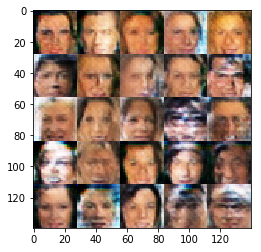

Epoch 1 Discriminator Loss: 1.369 Generator Loss: 0.724
Epoch 1 Discriminator Loss: 1.376 Generator Loss: 0.687
Epoch 1 Discriminator Loss: 1.386 Generator Loss: 1.224
Epoch 1 Discriminator Loss: 1.196 Generator Loss: 0.800
Epoch 1 Discriminator Loss: 1.336 Generator Loss: 0.731
Epoch 1 Discriminator Loss: 1.415 Generator Loss: 0.686
Epoch 1 Discriminator Loss: 1.303 Generator Loss: 0.908
Epoch 1 Discriminator Loss: 1.221 Generator Loss: 0.699
Epoch 1 Discriminator Loss: 1.372 Generator Loss: 0.980
Epoch 1 Discriminator Loss: 1.399 Generator Loss: 0.842


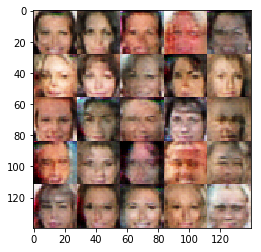

Epoch 1 Discriminator Loss: 1.287 Generator Loss: 1.195
Epoch 1 Discriminator Loss: 1.472 Generator Loss: 0.982
Epoch 1 Discriminator Loss: 1.081 Generator Loss: 0.806
Epoch 1 Discriminator Loss: 1.444 Generator Loss: 0.604
Epoch 1 Discriminator Loss: 1.215 Generator Loss: 0.809
Epoch 1 Discriminator Loss: 1.308 Generator Loss: 0.673
Epoch 1 Discriminator Loss: 1.112 Generator Loss: 0.708
Epoch 1 Discriminator Loss: 1.318 Generator Loss: 0.742
Epoch 1 Discriminator Loss: 1.562 Generator Loss: 0.589
Epoch 1 Discriminator Loss: 1.345 Generator Loss: 0.744


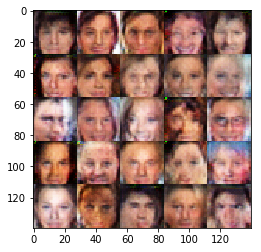

Epoch 1 Discriminator Loss: 1.336 Generator Loss: 0.808
Epoch 1 Discriminator Loss: 1.227 Generator Loss: 0.690
Epoch 1 Discriminator Loss: 1.354 Generator Loss: 0.744
Epoch 1 Discriminator Loss: 1.298 Generator Loss: 0.644
Epoch 1 Discriminator Loss: 1.313 Generator Loss: 0.747
Epoch 1 Discriminator Loss: 1.406 Generator Loss: 0.757
Epoch 1 Discriminator Loss: 1.358 Generator Loss: 0.681
Epoch 1 Discriminator Loss: 1.318 Generator Loss: 0.966
Epoch 1 Discriminator Loss: 1.306 Generator Loss: 0.636
Epoch 1 Discriminator Loss: 1.352 Generator Loss: 0.746


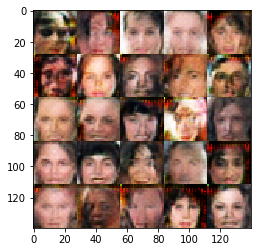

Epoch 1 Discriminator Loss: 1.323 Generator Loss: 0.739
Epoch 1 Discriminator Loss: 1.341 Generator Loss: 0.711
Epoch 1 Discriminator Loss: 1.385 Generator Loss: 0.775
Epoch 1 Discriminator Loss: 1.380 Generator Loss: 0.714
Epoch 1 Discriminator Loss: 1.342 Generator Loss: 0.703
Epoch 1 Discriminator Loss: 1.416 Generator Loss: 0.788


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.